<a href="https://colab.research.google.com/github/arjuntheprogrammer/GoogleMLCrashCourse/blob/master/Case_Study_Debugging_in_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case Study: Debugging in Classification

This Colab quickly demonstrates a few concepts related to debugging classification models. You will explore potential problems in implementing these tasks:

* Calculating loss for classification problems.
* Optimizing your model
* Applying regularization.
* Following best practices in development and debugging.

Please **make a copy** of this Colab before running it. Click on *File*, and then click on *Save a copy in Drive*.

## Load MNIST Data

MNIST is a dataset of images of the numbers 0 to 9. The problem is to classify the images as numbers. Setup libraries and load the MNIST dataset. Display the first few rows to verify that the data loaded. You'll explore the data format after the data loads.

In [13]:
# Reset environment for a new run

%reset -f
%matplotlib inline

# Load Libraries
from os.path import join # for joining file pathnames
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import unittest
import sys

# Set Pandas display options
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

# Load data
mnistDf_backup = pd.read_csv(
  "https://download.mlcc.google.com/mledu-datasets/mnist_train_small.csv",
  sep=",",
  header=None)
# Shuffle data
mnistDf_backup.sample(frac=1).reset_index(drop=True)
# Use the first 5000 examples for faster prototyping
mnistDf = mnistDf_backup[0:5000]

mnistDf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Understanding the Data Format

Each row represents one labeled example. Column 0 represents the label that a human rater has assigned for one handwritten digit. For example, if Column 0 contains '6', then a human rater interpreted the handwritten character as the digit '6'.  The ten digits 0-9 are each represented, with a unique class label for each possible digit. Thus, this is a multi-class classification problem with 10 classes.

![img](https://www.tensorflow.org/versions/r0.11/images/MNIST-Matrix.png)

Columns 1 through 784 contain the feature values, one per pixel for the 28×28=784 pixel values. The pixel values are on a gray scale in which 0 represents white, 255 represents black, and values between 0 and 255 represent shades of gray. Most of the pixel values are 0; you may want to take a minute to confirm that they aren't all 0.  Modify the form below and run the code to view data for a given example.

In [0]:
showExample = 1000 # @param
digitData = np.reshape(mnistDf.iloc[showExample,0:-1],[28,28])
print (digitData)

## Do you have Imbalanced Classes?

As we read in the course, imbalanced classes make classification harder. Let's look at the distribution of classes. Do you have imbalanced classes?

([<matplotlib.axis.XTick at 0x7f1a94787048>,
 <a list of 11 Text xticklabel objects>)

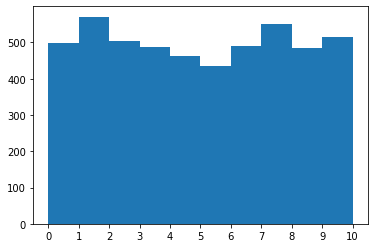

In [16]:
# Calculate the number of classes
numClasses = mnistDf.iloc[:,0].unique().shape[0]
# Plot histogram of class distribution
plt.hist(mnistDf.iloc[:,0], bins=range(numClasses+1))
plt.xticks(range(numClasses+1))

The preceding graph shows that the 10 classes are roughly equally represented.

## Shuffle and Split Dataset

As part of [Data Debugging](https://developers.google.com/machine-learning/testing-debugging/common/data-errors) best practices, ensure your splits are statistically equivalent by shuffling your data to remove any pre-existing order.

In [0]:
# Shuffle data
mnistDf = mnistDf.sample(frac=1).reset_index(drop=True)

# Split dataset into data and labels
mnistData = mnistDf.iloc[:,1:-1].copy(deep=True)
mnistLabels = mnistDf.iloc[:,0].copy(deep=True)

## Process Data

Scale the data values to `[0,1]` since the values are bounded to `[0,255]` and do not contain outliers. Then check that the scaled data values are as expected by generating summary statistics using the `DataFrame.describe()` function.

Run the following cell to scale data and generate statistics. This cell takes a few minutes to run.

In [18]:
def minMaxScaler(arr):
  min = np.min(arr)
  max = np.max(arr)
  arr = (arr-min)/max
  return arr

for featureIdx in range(mnistData.shape[1]):
  mnistData.iloc[:,featureIdx] = minMaxScaler(mnistData.iloc[:,featureIdx])

mnistData.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5000.0,5000.0,5000.0,5000.0,5000.0,...,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,0.0,0.0,0.0
mean,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,nan
std,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,...,0.1,0.1,0.1,0.1,0.1,0.0,0.0,0.0,0.0,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,nan
min,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,nan
25%,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,nan
50%,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,nan
75%,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,nan
max,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,nan,nan,nan


Oh no! Some of your features are all `NaN`. What do you think the cause is? Hint: While NaNs have many causes, in this case, the NaN values are caused by the properties of your data. Use the next code cell to explore your data. Then check the next cell for the solution. Try to find the solution yourself. Debugging `NaN`s and exploring your data are important skills.

In [0]:
# First reload your data
mnistData = mnistDf.iloc[:,1:-1].copy(deep=True)

Start exploring your data by generating a high-level summary using `Dataframe.describe()`.

In [20]:
mnistData.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,...,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.1,0.2,...,4.9,4.0,2.6,1.6,1.1,0.6,0.3,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.2,0.4,0.5,0.6,0.6,0.7,0.8,0.7,0.5,0.3,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,4.0,2.1,2.6,5.5,...,30.8,28.0,21.9,17.8,14.5,11.1,7.6,4.5,1.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.8,3.4,5.1,5.4,9.0,9.9,11.2,10.5,12.0,12.0,11.0,9.4,7.7,5.2,1.0,0.6,3.5,0.9,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,253.0,133.0,133.0,253.0,...,255.0,255.0,255.0,255.0,255.0,255.0,253.0,255.0,62.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,128.0,190.0,253.0,203.0,253.0,255.0,255.0,254.0,255.0,255.0,253.0,254.0,253.0,254.0,68.0,43.0,244.0,62.0,0.0,0.0,0.0


Because some of the feature columns are all zeros, the scaling function divided by 0 (because `np.max` returns 0). The division by 0 resulted in NaN values. This result shows you how easily NaNs can arise in engineered data. The `describe` function will not detect every occurrence of NaN (or None). Instead,  use the command `DataFrame.isnull().any()`.

*Note*: Given the maximum value of the feature data is 255, you could simply divide the input by 255 instead of using min-max scaling, and avoid introducing NaNs. However, this example purposely uses min-max scaling to show how NaNs can appear in engineered data.

Now let's try scaling the data again.

In [0]:
# Redefine the scaling function to check for zeros
def minMaxScaler(arr):
  max = np.max(arr)
  if(max!=0):  # avoid /0
    min = np.min(arr)
    arr = (arr-min)/max
  return arr

# Reload data
mnistData = mnistDf.iloc[:,1:-1].copy(deep=True)

# Scale data
for featureIdx in range(mnistData.shape[1]):
  mnistData.iloc[:,featureIdx] = minMaxScaler(mnistData.iloc[:,featureIdx])

You should follow best practice and prevent this bug from recurring by writing a unit test to check for not having `NaN` values in your engineered data.

## Remove All-Zero Features?

You might think that getting NaNs and discovering that some features were all-zero is good luck because those features can be discarded. However, your training data and validation data might have different all-zero features. Since you should not use validation data to make modeling decisions, you cannot remove only those features that are all-zero in both. Furthermore, data in the future might have different characteristics. There are pros and cons in either case. This Colab keeps the features since reducing the feature set is not a concern.

## Establish Baseline

Following development best practices, you should establish a baseline. The simplest baseline is predicting the most common class. You saw that the most common class is 1. Let's check the accuracy when always predicting 1.

In [22]:
np.sum(mnistLabels==1)*1.0/mnistLabels.shape[0]*100

11.42

Your baseline accuracy is about 11%. Should be easy to beat, right?

## Train a Linear Model

Let's start nice and easy with a linear model. All we need is an accuracy > 11%.

First, let's define a function to plot our loss and accuracy curves. The function will also print the final loss and accuracy. Instead of using `verbose=1`, you can call the function.

In [0]:
def showClassificationResults(trainHistory):
  """Function to:
   * Print final loss & accuracy.
   * Plot loss & accuracy curves.

  Args:
    trainHistory: object returned by model.fit
  """

  # Print final loss and accuracy
  print("Final training loss: " + str(trainHistory.history['loss'][-1]))
  print("Final validation loss: " + str(trainHistory.history['val_loss'][-1]))
  print("Final training accuracy: " + str(trainHistory.history['acc'][-1]))
  print("Final validation accuracy: " + str(trainHistory.history['val_acc'][-1]))

  # Plot loss and accuracy curves
  f = plt.figure(figsize=(10,4))
  axLoss = f.add_subplot(121)
  axAcc = f.add_subplot(122)
  axLoss.plot(trainHistory.history['loss'])
  axLoss.plot(trainHistory.history['val_loss'])
  axLoss.legend(['Training loss', 'Validation loss'], loc='best')
  axLoss.set_xlabel('Training epochs')
  axLoss.set_ylabel('Loss')
  axAcc.plot(trainHistory.history['acc'])
  axAcc.plot(trainHistory.history['val_acc'])
  axAcc.legend(['Training accuracy', 'Validation accuracy'], loc='best')
  axAcc.set_xlabel('Training epochs')
  axAcc.set_ylabel('Accuracy')

Now train a linear model with an output layer and a hidden layer.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Final training loss: 3.4777984023094177
Final validation loss: 3.52645857334137
Final training accuracy: 0.14875
Final validation accuracy: 0.125


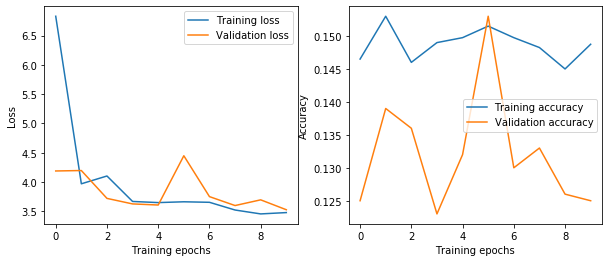

In [24]:
model = None
# Define
model = keras.Sequential()
model.add(keras.layers.Dense(mnistData.shape[1],
                             activation='linear',
                             input_dim=mnistData.shape[1]))
model.add(keras.layers.Dense(1, activation='linear'))
# Compile
model.compile(optimizer="adam", loss='mse', metrics=['accuracy'])
# Train
trainHistory = model.fit(mnistData, mnistLabels, epochs=10, batch_size=100,
                         validation_split=0.2, verbose=0)
# Plot
showClassificationResults(trainHistory)

Wow, that accuracy is terrible! What could the cause be?

Hint: You followed the same procedure as for the previous regression problem. Do you need an adaptation for a classification problem? Experiment with the code above or skip to the solution below.

In regression, the last layer uses a linear activation function. In classification, the last layer cannot use a linear transform. Instead, one option is a softmax transform. Furthermore, in regression, the loss is calculated using MSE while in classification, loss is calculated using crossentropy. Before running your model, if you wrote a test to validate the output values, your test would detect the anomalous output. You'll look at such a test later. Move onto the next section to fix the loss calculation.

## Fixing Loss Calculation

Since your labels are integers instead of one-hot encodings, use `sparse_categorical_crossentropy` instead of `categorical_crossentropy` so that you avoid converting the integers to one-hot encoding.

Retrain the model with the new loss calculation by running the following cell. Look through the code to note the changes. What do you think of the result?

Final training loss: 0.1818176441722446
Final validation loss: 0.23550230860710145
Final training accuracy: 0.9491111
Final validation accuracy: 0.926


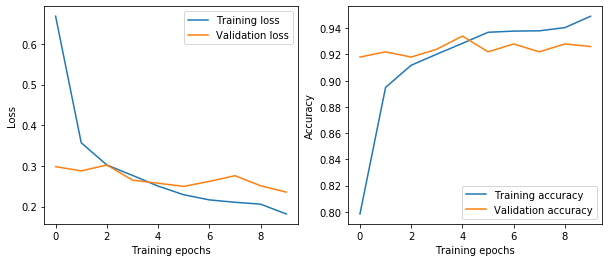

In [25]:
model = None
# Define
model = keras.Sequential()
model.add(keras.layers.Dense(mnistData.shape[1], activation='linear',
                             input_dim = mnistData.shape[1]))
model.add(keras.layers.Dense(10, activation='softmax'))
# Compile
model.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# Train
trainHistory = model.fit(mnistData, mnistLabels, epochs=10, batch_size=100,
                         validation_split=0.1, verbose=0)
# Plot
showClassificationResults(trainHistory)

Your loss curves are much better. Your accuracy has improved too. You're on the right track.

## Train a Nonlinear Model

Switch to a nonlinear model by modifying the code below to use relu activation functions instead of linear activation functions. Run the code. What do you observe?

Final training loss: 0.004772340718449818
Final validation loss: 0.09417552277445793
Final training accuracy: 1.0
Final validation accuracy: 0.972


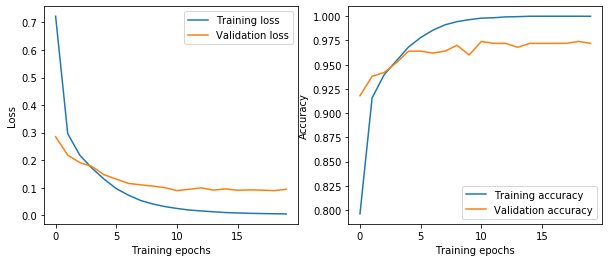

In [26]:
model = None
# Define
model = keras.Sequential()
model.add(keras.layers.Dense(mnistData.shape[1], activation='relu', # use 'relu'
                             input_dim=mnistData.shape[1]))
model.add(keras.layers.Dense(10, activation='softmax'))
# Compile
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# Train
trainHistory = model.fit(mnistData, mnistLabels, epochs=20, batch_size=100,
                        validation_split=0.1, verbose=0)
# Plot
showClassificationResults(trainHistory)

The quality of the nonlinear model is significantly better than of the linear model. Progress! Move onto the next section.

## Adding a Second Layer

Increasing the model's capacity significantly improved your results. Perhaps you can continue this strategy by adding a second relu layer. Run the following code cell to train the model with another relu layer.

Final training loss: 0.0015367255054621232
Final validation loss: 0.08666099905967713
Final training accuracy: 1.0
Final validation accuracy: 0.97


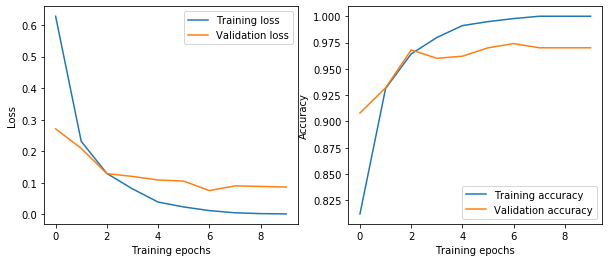

In [27]:
model = None
# Define
model = keras.Sequential()
model.add(keras.layers.Dense(mnistData.shape[1], activation='relu',
                             input_dim = mnistData.shape[1]))
model.add(keras.layers.Dense(mnistData.shape[1], activation='relu'))
model.add(keras.layers.Dense(10,activation='softmax'))
# Compile
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# Train
trainHistory = model.fit(mnistData, mnistLabels, epochs=10, batch_size=100,
                        validation_split=0.1, verbose=0)
# Plot
showClassificationResults(trainHistory)

Guess what. Your previous model had training and validation accuracies of 100% and 95%. You can't do much better than that! So your new accuracy is about the same. How high can you push your accuracy? With this configuration the highest training and validation accuracies appear to be 100% and 96% respectively. Since the neural net returns similar accuracy with 1 or 2 layers, let's use the simpler model with 1 layer.

Does your model begin to overfit the training data if you train for long enough? (Your model starts overfitting training data at the point when your validation loss starts increasing.)

## Check for Training/Validation Data Skew

Our validation accuracy is a little worse than our training accuracy. While this result is always expected, you should check for typical errors. The commonest cause is having different distributions of data and labels in training and validation. Confirm that the distribution of classes in training and validation data is similar.

([<matplotlib.axis.XTick at 0x7f1a2bedadd8>,
 <a list of 11 Text xticklabel objects>)

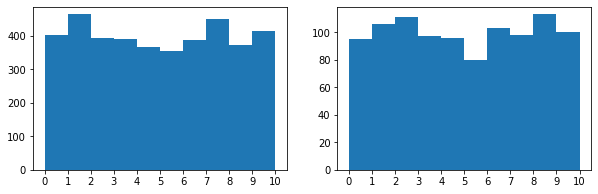

In [31]:

f = plt.figure(figsize=(10,3))
ax = f.add_subplot(1,2,1)
plt.hist(mnistLabels[0:int(len(mnistLabels)*8/10)], bins=range(numClasses+1))
plt.xticks(range(numClasses+1))
ax2 = f.add_subplot(1,2,2,)
plt.hist(mnistLabels[int(len(mnistLabels)*8/10):-1], bins=range(numClasses+1))
plt.xticks(range(numClasses+1))

## Apply Dropout Regularization

Dropout regularization is a common regularization method that removes a random selection of a fixed number of units in a network layer for a single gradient step. Typically, dropout will improve generalization at a dropout rate of between 10% and 50% of neurons. 

Try to reduce the divergence between training and validation loss by using dropout regularization with values between 0.1 and 0.5. Dropout does not improve the results in this case. However, at a dropout of 0.5, the difference in loss decreases, though both training and validation loss decrease in absolute terms.

Using TensorFlow backend.


Final training loss: 0.1220766372150845
Final validation loss: 0.13917820155620575
Final training accuracy: 0.96511114
Final validation accuracy: 0.96


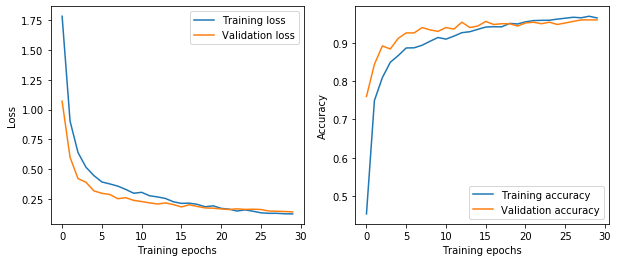

In [32]:
from keras import regularizers
model = None
# Define lambda
dropoutLambda = 0.5 #@param
# Define model
model = keras.Sequential()
model.add(keras.layers.Dense(mnistData.shape[1],
                             input_dim=mnistData.shape[1],
                             activation='relu'))
model.add(keras.layers.Dropout(dropoutLambda,
                               noise_shape=(1, mnistData.shape[1])))
model.add(keras.layers.Dense(10, activation='softmax'))
# Compile
model.compile(optimizer = "adam",
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
# Train
trainHistory = model.fit(mnistData,
                        mnistLabels,
                        epochs=30,
                        batch_size=500,
                        validation_split=0.1,
                        verbose=0)
# Plot
showClassificationResults(trainHistory)

Sample results using dropout regularization after 30 epochs:

Lambda | Training Loss | Validation Loss
------- | ------------------------------------------------------
0.1 | 0.99 | 0.95
0.2 | 0.99 | 0.95
0.3 | 0.99 | 0.95
0.5 | 0.97 | 0.94

## Check Accuracy for Data Slices

For classification problems, you should always check the metrics by class to ensure your model predicts well across all classes. Check accuracy on the 10 classes by running the next cell by using the function `sklearn.metrics.classification_report` from the scikit-learn library. In the output, the rows with indices 0 to 9 correspond to the classes for the labels 0 to 9. The columns "Precision", "Recall", and "[F1-Score](https://en.wikipedia.org/wiki/F1_score)" correspond to the respective classification metrics for each class. "Support" is the number of examples for the class in question. For example, for the label "4", when predicting on 464 examples labelled "4", the model has a precision of 0.98, a recall of 0.97, and a F1 score of 0.98.

The classification metrics are very uniform across all classes, which is perfect. In your classification problem, in case any metric is lower for a class, then you should investigate why the model has lower-quality predictions for that class.

In [33]:
from sklearn.metrics import classification_report
mnistPred = model.predict_classes(x = mnistData)
print(classification_report(mnistLabels, mnistPred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       499
           1       0.97      0.99      0.98       571
           2       0.97      0.98      0.98       504
           3       0.97      0.97      0.97       487
           4       0.97      0.97      0.97       464
           5       1.00      0.96      0.98       434
           6       0.99      0.99      0.99       491
           7       0.98      0.97      0.98       550
           8       0.98      0.99      0.98       485
           9       0.97      0.96      0.96       515

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



## Testing for Anomalous Values

In the section [Train a Linear Model](https://colab.corp.google.com/google_src/cloud/karangill/mlcc/google3/engedu/ml/capitalg/colab/testing_debugging_classification.ipynb#scrollTo=B6AOgLcC5nwp), you debugged an incorrect calculation of loss. Before running your model, if you wrote a test to validate the output values, your test would detect the anomalous output. For example, you could test whether the distribution of predicted labels on the training dataset is similar to the actual distribution of training labels. A simple statistical implementation of this concept is to compare the standard deviation and mean of the predicted and actual labels.

First, check the standard deviation and mean of the actual labels.

In [34]:
print("Mean of actual labels: " + str(np.mean(mnistLabels)))
print("Standard deviation of actual labels: " + str(np.std(mnistLabels)))

Mean of actual labels: 4.4754
Standard deviation of actual labels: 2.914754679214006


Write tests to check if the mean and standard deviation of the predicted labels falls within the expected range. The expected range defined in the tests below is somewhat arbitrary. In practice, you will tune the range thresholds to accommodate natural variation in predictions.

In [0]:
class mlTest(unittest.TestCase): 
  '''Class to test statistics of predicted output on training data against
     statistics of labels to validate that model predictions are in the]
     expected range.
  '''
     
  def testStd(self):
    y = model.predict(mnistData)
    yStd = np.std(y)
    yStdActual = np.std(mnistLabels)
    deltaStd = 0.05
    errorMsg = 'Std. dev. of predicted values ' + str(yStd) + \
               ' and actual values ' + str(yStdActual) + \
               ' differs by >' + str(deltaStd) + '.'
    self.assertAlmostEqual(yStd, yStdActual, delta=deltaStd, msg=errorMsg)

  def testMean(self):
    y = model.predict(mnistData)
    yMean = np.mean(y)
    yMeanActual = np.mean(mnistLabels)
    deltaMean = 0.05
    errorMsg = 'Mean of predicted values ' + str(yMean) + \
               ' and actual values ' + str(yMeanActual) + \
               ' differs by >' + str(deltaMean) + '.'
    self.assertAlmostEqual(yMean, yMeanActual, delta=deltaMean, msg=errorMsg)

Run the following cell to train a model with the wrong loss calculation and execute the tests. The tests should fail.

In [36]:
#@title Train model and run tests

model = None
# Define
model = keras.Sequential()
model.add(keras.layers.Dense(mnistData.shape[1],
                             activation='linear',
                             input_dim=mnistData.shape[1]))
model.add(keras.layers.Dense(1, activation='linear'))
# Compile
model.compile(optimizer="adam", loss='mse', metrics=['accuracy'])
# Train
trainHistory = model.fit(mnistData, mnistLabels, epochs=10, batch_size=100,
                         validation_split=0.1, verbose=0)

suite = unittest.TestLoader().loadTestsFromTestCase(mlTest)
unittest.TextTestRunner(verbosity=1, stream=sys.stderr).run(suite)

.F
FAIL: testStd (__main__.mlTest)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-35-f8aa3a0ebb02>", line 13, in testStd
    self.assertAlmostEqual(yStd, yStdActual, delta=deltaStd, msg=errorMsg)
AssertionError: 2.3492973 != 2.914754679214006 within 0.05 delta : Std. dev. of predicted values 2.3492973 and actual values 2.914754679214006 differs by >0.05.

----------------------------------------------------------------------
Ran 2 tests in 0.346s

FAILED (failures=1)


<unittest.runner.TextTestResult run=2 errors=0 failures=1>

Since the tests fail, check the data distribution of predicted labels for anomalies.

(array([237., 638., 643., 673., 682., 710., 549., 464., 260.,  86.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 10 Patch objects>)

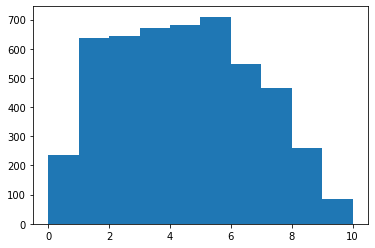

In [37]:
yPred = model.predict(mnistData)
plt.hist(yPred, bins=range(11))

Given equally represented classes, the predicted labels are clearly skewed. From this plot, a possible explanation is that your loss calculation does not appear to be weighting all classes equally. This anomaly is a hint that your loss calculation is incorrect.

## Optional: Pass Tests by Fixing Loss Calculation

As an optional exercise, you can attempt to pass the tests by fixing the loss calculation. You will need to:
1. Fix the loss calculation by setting the output layer's activation to `softmax`.
1. Set the model's loss to `sparse_categorical_crossentropy`.
1. Set the number of units in the output layer to 10 corresponding to the 10 classes.
1. Adapt the tests to the modified output layer.

## Conclusion

The Colab demonstrated the following principles:

* Calculate loss correctly for your problem.
* Verify and unit test your engineered data.
* Find the right model capacity through experimentation.
* Find the best regularization through experimentation.
* Check quality on data slices.